# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

* geo_data_0.csv. Скачать датасет: https://code.s3.yandex.net/datasets/geo_data_0.csv
* geo_data_1.csv. Скачать датасет: https://code.s3.yandex.net/datasets/geo_data_1.csv
* geo_data_2.csv. Скачать датасет: https://code.s3.yandex.net/datasets/geo_data_2.csv

**Данные таблицы**: 

1. **id** — уникальный идентификатор скважины.

2. **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы).

3. **product** — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Открытие и изучение файлов

Импортируем требуемые библиотеки:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Прочитаем файлы и сохраним датасеты в переменных *geo_data_0*, *geo_data_1*, *geo_data_2*:

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv') 
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на таблицы:

In [3]:
# с помощью цикла выведим на экран первые строки датасетов

for data in geo_data_0, geo_data_1, geo_data_2:
    head = data.head()
    print(head)
    print('--------------------------------------------------')    

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
--------------------------------------------------
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
--------------------------------------------------
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993 

Проверим общую информацию: 

In [4]:
# с помощью цикла получим общую информацию о датасетах

for data in geo_data_0, geo_data_1, geo_data_2:
    info = data.info()
    print(info)
    print('--------------------------------------------------')  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2   

Пропускив нет. Кроме колонки *id*, остальные данные имеют вещественный тип. 

Проверим таблицу на наличие дубликатов:

In [5]:
# с помощью цикла проверим дубликаты 
for data in geo_data_0, geo_data_1, geo_data_2:
    duplicates = data.duplicated().sum()
    print(duplicates)

0
0
0


In [6]:
# с помощью цикла проверим дубликаты в столбце 'id'
for data in geo_data_0, geo_data_1, geo_data_2:
    duplicates = data['id'].duplicated().sum()
    print(duplicates)

10
4
4


Дубликаты обнаружены только в столбце *id*. Этот столбец не будет использоваться в дальнейшей работе, поэтому оставим его без изменений. 

### Визуализация данных 

Построем график «ящик с усами» по объемам нефти в разных регионах и посмотрим, велика ли разница. 

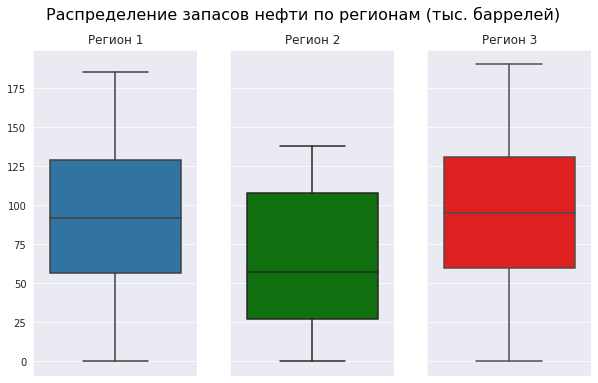

In [7]:
fig,  ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

sns.boxplot(geo_data_0['product'], orient='v', ax=ax[0]).set(ylabel=None, title='Регион 1')
sns.boxplot(geo_data_1['product'], orient='v', ax=ax[1], color='g').set(ylabel=None, title='Регион 2')
sns.boxplot(geo_data_2['product'], orient='v', ax=ax[2], color='r').set(ylabel=None, title='Регион 3')

fig.suptitle('Распределение запасов нефти по регионам (тыс. баррелей)', fontsize = 16, color='black')
plt.show()

Первый и третий регионы практически полностью совпадают. Объем нефти во втором регионе меньше. Судя по медиане и "усам", значения в первом и втором регионах симметричны. Во втором - несколько ассиметричны и смещены в меньшую сторону, но и разброс здесь меньше. Выбросов нет. 

Теперь построим гистограмму по объемам нефти в разных регионах и посмотрим на распределение: 

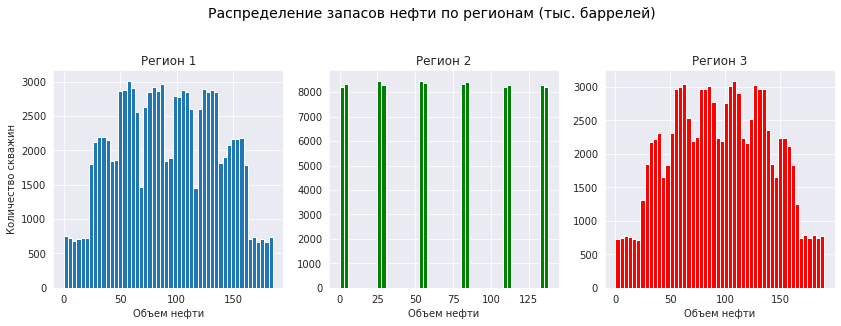

In [8]:
fig,  ax = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Распределение запасов нефти по регионам (тыс. баррелей)', y=1.1, fontsize = 14, color='black')

geo_data_0['product'].plot(kind='hist', bins=50, ax=ax[0]).set(xlabel='Объем нефти', ylabel='Количество скважин', title='Регион 1')
geo_data_1['product'].plot(kind='hist', bins=50, ax=ax[1], color='g').set(xlabel='Объем нефти',  ylabel=None, title='Регион 2')
geo_data_2['product'].plot(kind='hist', bins=50, ax=ax[2], color='r').set(xlabel='Объем нефти', ylabel=None, title='Регион 3')

plt.show()

Распределения во всех случаях ненормальное. Во втором регионе оно еще и дискретное.

Визуализируем распределение данных признаков в каждом из регионов:

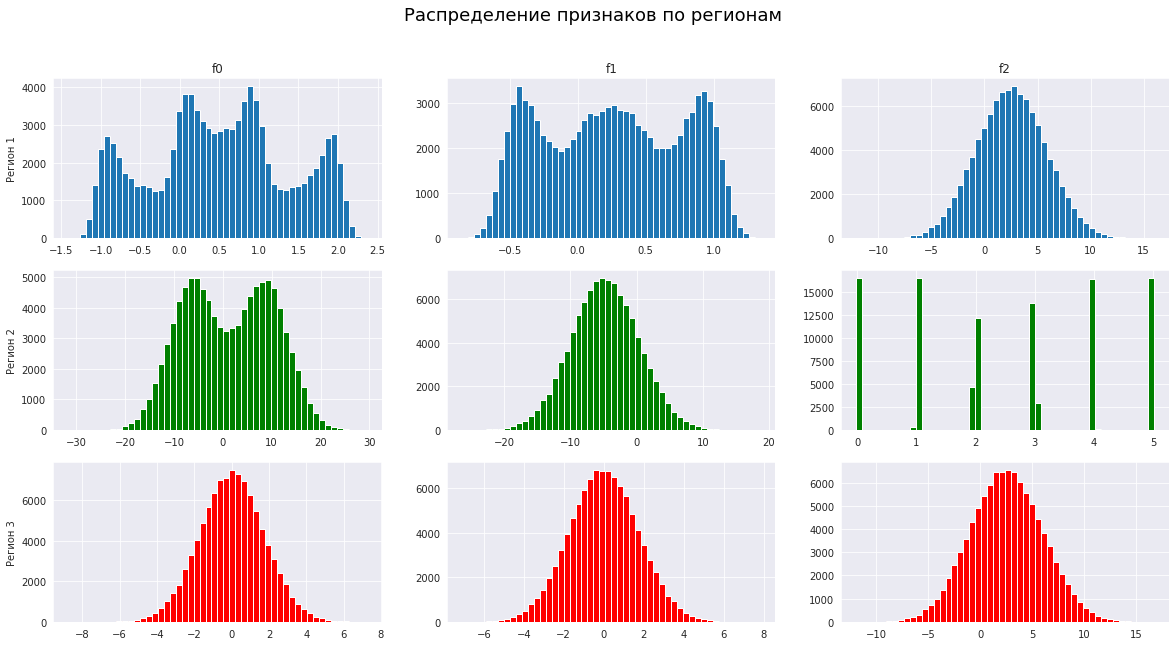

In [9]:
fig,  ax = plt.subplots(3, 3, figsize=(20, 10))
fig.suptitle('Распределение признаков по регионам', fontsize = 18, color='black')

geo_data_0['f0'].plot(kind='hist', bins=50, ax=ax[0,0]).set(ylabel='Регион 1', title='f0')
geo_data_0['f1'].plot(kind='hist', bins=50, ax=ax[0,1]).set(xlabel=None, ylabel=None, title='f1')
geo_data_0['f2'].plot(kind='hist', bins=50, ax=ax[0,2]).set(xlabel=None, ylabel=None, title='f2')

geo_data_1['f0'].plot(kind='hist', bins=50, ax=ax[1,0], color='g').set(xlabel=None, ylabel='Регион 2')
geo_data_1['f1'].plot(kind='hist', bins=50, ax=ax[1,1], color='g').set(xlabel=None, ylabel=None)
geo_data_1['f2'].plot(kind='hist', bins=50, ax=ax[1,2], color='g').set(xlabel=None, ylabel=None)

geo_data_2['f0'].plot(kind='hist', bins=50, ax=ax[2,0], color='r').set(xlabel=None, ylabel='Регион 3')
geo_data_2['f1'].plot(kind='hist', bins=50, ax=ax[2,1], color='r').set(xlabel=None, ylabel=None)
geo_data_2['f2'].plot(kind='hist', bins=50, ax=ax[2,2], color='r').set(xlabel=None, ylabel=None)

plt.show()

Только в регионе 3 все признаки имеют нормальное гауссово распределение. В первом и втором регионе нормальными являются только по одному признаку - *f2* и *f1* соответственно. Интерес представляет признак *f2* во втором регионе: подобное дискретное распределение данных, как и в целевом признаке.

**Построим матрицу корреляции и посмотрим на зависимости:**

In [10]:
# Значения корреляции для Региона 1
corr_0 = geo_data_0.corr()
corr_0.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,-0.440723,-0.00315334,0.143536
f1,-0.440723,1,0.00172443,-0.192356
f2,-0.00315334,0.00172443,1,0.483663
product,0.143536,-0.192356,0.483663,1


In [11]:
# Значения корреляции для Региона 2
corr_1 = geo_data_1.corr()
corr_1.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,0.182287,-0.00177704,-0.0304905
f1,0.182287,1,-0.00259532,-0.0101549
f2,-0.00177704,-0.00259532,1,0.999397
product,-0.0304905,-0.0101549,0.999397,1


In [12]:
# Значения корреляции для Региона 3
corr_2 = geo_data_2.corr()
corr_2.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,0.000528283,-0.000448133,-0.00198706
f1,0.000528283,1,0.000778661,-0.00101239
f2,-0.000448133,0.000778661,1,0.445871
product,-0.00198706,-0.00101239,0.445871,1


Признак *f2* значительно влияет на объем нефти, что особенно характерно для Региона 2. 

# Вывод

Данные проверены:

* Пропусков нет; 
* Обнаружили несколько повторов уникальных идентификаторов скважин, но нет необходимости их удалять;
* Визуализировали данные по объему нефти. В Регионах 1 и 3 нефти больше, чем в Регионе 2;
* Распределение данных по объему нефти во всех регионах ненормальное. В Регионе 2 к тому же еще и дискретное.
* Только в Регионе 3 все три признака имеют гауссово распределение. В Регионе 2 в признаке *f2* значения распределены дискретно. 
* Очевидна положительная корреляция признака *f2* с целевым признаком, особенно для Региона 2.

Данные не требуют никаких исправлений. Можем приступать к исследованию.

## Обучение и проверка модели

Согласно проекту для обучения модели подходит только линейнай регрессия. Ее и будем использовать.

Для обучения модели создадим функцию, в которой:

* подготовим данные для обучения, разбив их на две выборки: обучающую и валидационную в соотношении 75:25;
* проведем обучение модели;
* вернем правильные ответы, предсказания, средний предсказанный объем нефти и значения метрики RMSE.

In [13]:
def region_prediction(region):
    
    # разделение данных на признаки (X) и целевую переменную (y)
    X = region[['f0', 'f1', 'f2']] # 
    y = region['product']
    
    # разбивка датасета на две выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
        
    model=LinearRegression() # создание модели линейной регрессии 
    predicted = pd.Series(model.fit(X_train, y_train).predict(X_valid), index=y_valid.index) # создание объекта данных 
                                                                                             # со списком предсказанных значений
  
    rmse = round(mean_squared_error(y_valid, predicted)**0.5, 3) # вычисление RMSE
    target_mean = round(region['product'].mean(), 3) # вычисление среднего реального объема запаса сырья
    pred_mean = round(predicted.mean(), 3) # вычисление среднего предсказанного объема запаса сырья
    
    return y_valid, predicted, rmse, target_mean, pred_mean # возвращение полученных результатов

Сохраним значения функции в переменных для каждого региона:

* target_geo[ i ] - значение реального объема сырья в скважине
* pred_geo[ i ] - значение предсказанного объем сырья в скважине
* rmse_geo[ i ] - значение метрики RMSE
* target_mean_geo[ i ] - среднее значение реального объема сырья в регионе
* pred_mean_geo[ i ] - среднее значение предсказанного объема сырья в регионе

In [14]:
target_geo_0, pred_geo_0, rmse_geo_0, target_mean_geo_0, pred_mean_geo_0 = region_prediction(geo_data_0) # значения Региона 1
target_geo_1, pred_geo_1, rmse_geo_1, target_mean_geo_1, pred_mean_geo_1 = region_prediction(geo_data_1) # значения Региона 2
target_geo_2, pred_geo_2, rmse_geo_2, target_mean_geo_2, pred_mean_geo_2 = region_prediction(geo_data_2) # значения Региона 3

Создадим таблицу с данными о среднем объеме нефти до и после предсказаний и со значениями RMSE:

In [15]:
geo_table = pd.DataFrame(data=[[target_mean_geo_0, pred_mean_geo_0, rmse_geo_0], 
                             [target_mean_geo_1, pred_mean_geo_1, rmse_geo_1], 
                             [target_mean_geo_2, pred_mean_geo_2, rmse_geo_2]],
                       index=['Регион 1', 'Регион 2', 'Регион 3'],
                       columns=['Реальный объем', 'Предсказанный объем', 'RMSE'])               
geo_table            

,Реальный объем,Предсказанный объем,RMSE
Регион 1,92.500,92.593,37.579
Регион 2,68.825,68.729,0.893
Регион 3,95.000,94.965,40.030


Модель предсказывает объем довольно точно. Средние значения объема сырья практически полностью совпадают. 

Значение RMSE лучшее во втором регионе. В своих предсказаниях модель ошибается в среднем всего лишь на 893 бареля.  В первом и третьем регионах разброс ошибок шире: 38-40 тыс баррелей соответсвенно.

# Вывод

Мы провели обучение модели в трех регионах и получили предсказания на валидационных данных. Средние запасы сырья во втором регионе меньше, чем в первом и третьем. Тем не менее, показатель RMSE указывает на практически максимальную точность модели Региона 2. Можно предположить, что это связано с высоким уровнем положительной корреляции признака *f2* с целевым признаком.

## Подготовка к расчёту прибыли

Прежде всего создадим константы для ключевых значений расчётов:

In [16]:
TOTAL_BUDGET = 10000000000 # Максимальный бюджет на разработку месторождений 
TOTAL_WELLS = 500 # Количество месторождений, исследуемых при разведке региона
BEST_WELLS = 200 # Количество месторождений с самым высокими оценками значений
BARREL_PROFIT = 450000 # Стоимость тысячи баррелей нефти 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

Передадим переменной *profit_mining* значение минимального объема нефти:

In [17]:
profit_mining = TOTAL_BUDGET / (BARREL_PROFIT * BEST_WELLS) # расчет точки безубыточности
profit_mining

111.11111111111111

Для безубыточной разработки новой скважины требуется добыть не менее 111.11 тыс. баррелей. Средний запас сырья на скважину в каждом из регионов ниже этого показателя. Предварительно можно заключить, что все регионы выглядят убыточными. 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [18]:
def revenue(target, predicted):
       
    probs_sorted = predicted.sort_values(ascending=False)
    target_selected = target[probs_sorted.index][:BEST_WELLS] # выбор таргетов по индексу, выбор лучших 200
    target_revenue = BARREL_PROFIT* target_selected.sum() - TOTAL_BUDGET # расчет вероятной прибыли
   
    return  round(target_revenue / 1000000000, 2) # значение прибыли в млрд 

# Вывод

Мы провели расчет требуемого минимального объема сырья для безубыточной разработки новой скважины. Месторождение со средним запасом нефти в скважине более 111 тыс. баррелей можно считать потенциально прибыльным.

## Расчёт прибыли и рисков 

Определим среднюю прибыль, 95%-й квантиль выручки и риск убытков при разработке скважин в каждом из регионов. Для этого выполним процедуру Bootstrap с 1000 повторениями. Создадим функцию, производящую все требуемые расчеты:

In [19]:
state=np.random.RandomState(12345)

def bootstrap_1000(targets, predicteds):
    
    values=[] 

    for i in range(1000):
        target_sample = targets.sample(n=TOTAL_WELLS, replace=True, random_state=state) # отбираем случайным образом 500 таргет значений
        probs_sample = predicteds[target_sample.index] # отбираем предсказанные значения по таргет_индексу
        profit = revenue(target_sample, probs_sample) # отсылаем в функцию прибыли таргет и предикт.
        values.append(profit) # отсылаем в функцию прибыли таргет и предикт.

    values = pd.Series(values)
    
    lower = round((values.quantile(0.05)), 2) # нижняя граница доверительного интервала средней прибыли
    upper = round((values.quantile(0.95)), 2) # верхняя граница доверительного интервала средней прибыли
    mean = round((values.mean()), 2) # средняя прибыль
    risk = round((values < 0).mean()*100, 2)  # средняя вероятность убытка в процентах
        
    return lower, upper, mean, risk 

Создадим переменным для значений функции:

* mean_geo[ i ] - значение среднего предсказанного объема сырья
* lower_geo[ i ] - значение нижней границы интервала
* upper_geo[ i ] - значение верхней границы интервала
* risk_geo[ i ] - значение средней вероятности убытка

In [20]:
lower_geo_0, upper_geo_0, mean_geo_0, risk_geo_0 = bootstrap_1000(target_geo_0, pred_geo_0) # значения Региона 1
lower_geo_1, upper_geo_1, mean_geo_1, risk_geo_1 = bootstrap_1000(target_geo_1, pred_geo_1) # значения Региона 2
lower_geo_2, upper_geo_2, mean_geo_2, risk_geo_2 = bootstrap_1000(target_geo_2, pred_geo_2) # значения Региона 3

Сформируем итоговую таблицу по регионам с полученными данными:

In [21]:
results = pd.DataFrame(data=[[mean_geo_0, (lower_geo_0, upper_geo_0), risk_geo_0], 
                             [mean_geo_1, (lower_geo_1, upper_geo_1), risk_geo_1], 
                             [mean_geo_2, (lower_geo_2, upper_geo_2), risk_geo_2]],
                       index=['Регион 1', 'Регион 2', 'Регион 3'],
                       columns=['Средняя прибыль', 'Доверительный интервал','Средний риск убытка'])               
results  

,Средняя прибыль,Доверительный интервал,Средний риск убытка
Регион 1,0.43,"(-0.03, 0.88)",5.9
Регион 2,0.52,"(0.19, 0.89)",0.2
Регион 3,0.42,"(-0.03, 0.91)",5.8


# Вывод

Результат работы показывает, что все регионы убыточны. Доход со скважин не окупает вложенний. Тем не менее, лучшим из регионов оказался Регион 1. 

# Общий вывод

1. Мы изучили информацию о геологических данных нефтедобывающей компании «ГлавРосГосНефть». Данные были абсолютно чистыми, за исключением единичных случаев дубликатов уникальных идентификаторов скважин. Отмечается положительная корреляция признака *f2* с целевым признакам: 0.45 - для Региона 1, 0.999 - для Региона 2, 0.48 - для Региона 3.

2. Используя линейную регрессию, мы провели обучение модели и сделали предсказания на валидационной выборке. Модели сделали предсказания среднего объема запаса нефти довольно точно. Однако, метрика RMSE показала сравнительно высокий разброс ошибок для Региона 1 и 3. Модель Региона 2 показала почти полную безошибочность предсказаний - RMSE = 0.893

3. Далее мы вычислили объем нефти (в тыс баррелей) для безубыточной разработки одной скважины - 111.11 тыс. Средний запас сырья на точку в каждом из регионов значительно ниже, что позволило предположить о безусловной убыточности всех регионов. 

4. С помощью техники Бутстреп произвели расчет предсказаний средней прибыли на скважину, 95% доверительный интервал и риск убыточности. В итоге получили довольно низкую прибыль в каждом регионе (в интервале 0.42-0.54 млрд дохода с региона).

Таким образом, компания «ГлавРосГосНефть» не стоит производить разработки ни в одном из регионов, так как даже минимальные вложения не окупятся.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован